In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from scipy.stats import pearsonr

In [ ]:
from model.util import Normalizer
from model.database_util import get_hist_file, get_job_table_sample, collator
from model.database_util import Encoding
from model.feature_encoding import EncodeDataset

In [4]:
# Load the histogram file
hist_file = get_hist_file('dataset/histogram.csv')
# Normalizer for cost
cost_norm = Normalizer(-3.61192, 12.290855)
# Normalizer for cardinality
card_norm = Normalizer(1, 100)
# Normalizer for knob settings (if applicable)
knob_norm = Normalizer()  # Adjust ranges based on your knob setting values


e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hist_file['freq'][i] = freq_np
e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:89: FutureWarning: ChainedAssignme

In [5]:
encoding_ckpt = torch.load('checkpoints/encoding.pt', map_location='cpu', weights_only=False)  
encoding = encoding_ckpt['encoding']  # Extracts the 'encoding' object from the checkpoint.

In [6]:
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(x)
else:
    print("CUDA is not available")

tensor([[-2.8537, -1.0287,  0.4927],
        [ 0.0745,  0.5076,  0.1001],
        [ 0.9314, -2.4198, -0.1367]], device='cuda:0')


In [7]:
import torch
print(torch.cuda.get_device_name(0))


NVIDIA GeForce GTX 1050 Ti


In [8]:
import json

data='./dataset/'
file = data+ 'trainingplans.csv'
train_data = pd.read_csv(file)

file = data+ 'validationplans.csv'
val_data = pd.read_csv(file)

In [9]:
train_data, val_data

(        id                                               json
 0     5000  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 1     5001  {"Plan": {"Node Type": "Index Scan", "Parallel...
 2     5002  {"Plan": {"Node Type": "Index Scan", "Parallel...
 3     5003  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 4     5004  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 ...    ...                                                ...
 4995  9995  {"Plan": {"Node Type": "Hash Join", "Parallel ...
 4996  9996  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 4997  9997  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 4998  9998  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 4999  9999  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 
 [5000 rows x 2 columns],
          id                                               json
 0     10000  {"Plan": {"Node Type": "Gather", "Parallel Awa...
 1     10001  {"Plan": {"Node Type": "Nested Loop", "Paralle...
 2     10002  {"Plan": {

In [15]:
import json

# Parse JSON in the 'json' column
train_data["json"] = train_data["json"].apply(json.loads)  # Convert JSON string to dict
val_data["json"] = val_data["json"].apply(json.loads)  # Convert JSON string to dict


In [16]:
table_sample = get_job_table_sample(data +'train')

Loaded queries with len  100000
Loaded bitmaps


In [17]:
to_predict = 'both'

In [18]:
# ✅ Initialize normalizer for knobs
knob_norm = Normalizer()

In [19]:
train_features = EncodeDataset(train_data, None, encoding, hist_file, card_norm, cost_norm, knob_norm, to_predict, table_sample)
val_features = EncodeDataset(val_data, None, encoding, hist_file, card_norm, cost_norm, knob_norm, to_predict, table_sample)


Total execution time is : [12697.475, 720.8, 0.156, 48306.063, 1065.787, 2175.218, 609.991, 1842.934, 988.295, 5059.574, 2810.742, 458.666, 4122.284, 354.175, 427.562, 40.554, 24215.846, 781.528, 2365.207, 3705.735, 452.075, 8.053, 138.685, 217.392, 2197.849, 296.367, 112.629, 2232.158, 7830.156, 2538.986, 4394.821, 0.383, 32.644, 0.724, 365.519, 700.259, 678.185, 2568.539, 3989.254, 4518.275, 2003.747, 4148.419, 625.795, 151.817, 2674.324, 764.432, 2253.83, 19606.794, 197.295, 7548.388, 2250.511, 3671.424, 21.212, 0.739, 88.911, 988.876, 1.093, 875.458, 1.141, 50444.931, 13.777, 5541.387, 2143.588, 1991.354, 2025.854, 572.97, 0.227, 10219.855, 373.953, 347.051, 2332.986, 283.218, 2151.366, 91.654, 67.1, 58378.451, 0.214, 2673.798, 434.225, 4055.17, 243.416, 14313.459, 5592.237, 166.402, 23909.025, 1887.536, 4.554, 30615.572, 28.481, 24321.809, 62.756, 2.716, 1582.007, 568.272, 11031.005, 19367.006, 836.449, 245.673, 865.38, 4006.341, 2397.017, 157.678, 12372.164, 3457.353, 505.137, 47

In [20]:
features, (cost_label, knob_label), weight = train_features[0]
print(f"Features shape: {features['x'].shape}")
print(f"Raw cost: {train_features.costs[0]}, Normalized: {cost_label}")
print(f"Raw knobs: {train_features.knob_settings[0]}")
print(f"Normalized knobs: {knob_label}")
print(f"Weight: {weight}")

Features shape: torch.Size([1, 30, 1189])
Raw cost: 12697.475, Normalized: 0.8213081955909729
Raw knobs: [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Normalized knobs: tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1.])
Weight: 7.875581561855756e-05


In [21]:
train_features.cost_labels

tensor([0.8213, 0.6409, 0.1107,  ..., 0.7128, 0.6214, 0.7809])

In [22]:
# def save_train_dataset_to_csv(train_ds, filename):
#     rows = []

#     for i in range(len(train_ds)):
#         # Extract collated_dicts and labels
#         # features, (cost_label, hint_label) = train_ds[i]
#         features, (cost_label, hint_label), _ = train_ds[i]
        
#         # Flatten features for easier CSV representation
#         features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
        
#         # Add cost label
#         features_flattened['cost_label'] = cost_label.item()  # This works because cost_label is a scalar
        
#         # Convert hint_label (knob settings) to a list and store it as a string
#         features_flattened['hint_label'] = ",".join(map(str, hint_label.numpy().tolist()))  
        
#         rows.append(features_flattened)
    
#     # Create DataFrame
#     df = pd.DataFrame(rows)
    
#     # Save to CSV
#     df.to_csv(filename, index=False)
#     print(f"Training dataset saved to {filename}")

def save_train_dataset_to_csv(train_ds, filename):
    import csv
    
    # Open CSV file for writing
    with open(filename, 'w', newline='') as csvfile:
        # Define fieldnames (35670 features + cost_label + hint_label)
        fieldnames = [f"feature_{j}" for j in range(30 * 1189)] + ['cost_label', 'hint_label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for i in range(len(train_ds)):
            features, (cost_label, hint_label), _ = train_ds[i]
            
            # Flatten features and write directly
            features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
            features_flattened['cost_label'] = cost_label.item()
            features_flattened['hint_label'] = ",".join(map(str, hint_label.numpy().tolist()))
            
            # Write row immediately
            writer.writerow(features_flattened)
    
    print(f"Training dataset saved to {filename}")

In [26]:
# save_train_dataset_to_csv(train_features, "out/traindata.csv")
save_train_dataset_to_csv(val_features, "out/valdata.csv")

Training dataset saved to out/valdata.csv


In [27]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd


def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_features_labels(data, hint_label_column, cost_label_column):
    X = data.drop(columns=[hint_label_column, cost_label_column])  # Keep features
    y_hints = data[hint_label_column]  # Hint Labels
    y_costs = data[cost_label_column]  # Cost Labels
    return X, y_hints, y_costs

def preprocess_features(X):
    # Standardize features for SVM (if numerical)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled


In [62]:
file_path = "dataset/updatedtrainigdata.csv"
hint_label_column = "hint_label"
cost_label_column = "cost_label"  # Ensure this column exists in CSV

data = read_csv(file_path)
X, y_hints, y_costs = extract_features_labels(data, hint_label_column, cost_label_column)


In [84]:
file_path = "dataset/val_18.csv"
hint_label_column = "hint_label"
cost_label_column = "cost_label"  # Ensure this column exists in CSV

valdata = read_csv(file_path)
X_val, y_hints_val, y_costs_val = extract_features_labels(valdata, hint_label_column, cost_label_column)


In [85]:
valdata

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_35662,feature_35663,feature_35664,feature_35665,feature_35666,feature_35667,feature_35668,feature_35669,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,"0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,"1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4924,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.681751,"1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4925,4.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.827338,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.540070,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4926,7.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,0.066940,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.062544,"0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0...."
4927,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.537657,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."


In [86]:
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_35662,feature_35663,feature_35664,feature_35665,feature_35666,feature_35667,feature_35668,feature_35669,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,"0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,"1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,"1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.0,0.0,10.0,9.0,0.0,0.0,1.0,0.0,0.100000,0.865876,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.049155,"0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0...."
4996,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.689908,"1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4997,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694614,"0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0...."
4998,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.787670,"0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0...."


In [87]:
# Convert X to DataFrame to use isnull
X_df = pd.DataFrame(X)
X_vdf=pd.DataFrame(X_val)
# Check if there are any missing values in the dataset
print(f"Missing values before scaling: {X_df.isnull().sum().sum()}")

Missing values before scaling: 0


In [88]:
# Preprocess features
X = preprocess_features(X)
X_val=preprocess_features(X_val)



In [89]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets for both hint labels and cost labels
X_train, X_test, y_hints_train, y_hints_test, y_cost_train, y_cost_test = train_test_split(
    X, y_hints, y_costs, test_size=0.2, random_state=42
)


In [90]:
# Convert to sets for strict comparison
train_tuples = set(map(tuple, X_train))
test_tuples = set(map(tuple, X_test))

# Find exact intersection (should be 0)
overlap = train_tuples & test_tuples
print(f"New Train-Test Overlap: {len(overlap)}") 

New Train-Test Overlap: 0


In [91]:
import numpy as np
import pandas as pd

def process_labels(y):
    if isinstance(y, pd.Series):
        y = y.astype(str).tolist()  # Convert Series to a list of strings
    elif isinstance(y, np.ndarray):
        y = y.tolist()  # Convert NumPy array to a list

    processed_labels = []
    for label in y:
        try:
            # Convert each entry from a comma-separated string to a list of floats
            processed_labels.append(list(map(float, label.split(','))) if isinstance(label, str) else label)
        except ValueError:
            print(f"Error processing label: {label}")  # Debugging
            processed_labels.append([])  # Handle incorrect formats safely

    # Convert to a NumPy array with dtype=float for multi-label compatibility
    return np.array(processed_labels, dtype=np.float32)



In [92]:

# Process labels for multi-label compatibility
y_hints_train = process_labels(y_hints_train)
y_hints_test = process_labels(y_hints_test)
y_cost_train = process_labels(y_cost_train)
y_cost_test = process_labels(y_cost_test)

y_hints_val=process_labels(y_hints_val)
y_costs_val=process_labels(y_costs_val)

# Verify shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_hints_train shape:", y_hints_train.shape)
print("y_hints_test shape:", y_hints_test.shape)
print("y_cost_train shape:", y_cost_train.shape)
print("y_cost_test shape:", y_cost_test.shape)


X_train shape: (4000, 35670)
X_test shape: (1000, 35670)
y_hints_train shape: (4000, 20)
y_hints_test shape: (1000, 20)
y_cost_train shape: (4000, 1)
y_cost_test shape: (1000, 1)


In [93]:
# Ensure y_hints and y_costs are NumPy arrays
y_hints_train = np.array(y_hints_train).astype(int)  # Convert to integer labels
y_hints_test = np.array(y_hints_test).astype(int)
y_cost_train = np.array(y_cost_train).astype(float)  # Cost values should be float
y_cost_test = np.array(y_cost_test).astype(float)

y_hints_val=np.array(y_hints_val).astype(int)
y_costs_val=np.array(y_costs_val).astype(float)

if len(y_hints_val.shape) > 1:
    y_hints_val = y_hints_val.argmax(axis=1)  # Convert multi-label to single-label
# Ensure single-class labels for hints (not multi-label lists)
if len(y_hints_train.shape) > 1:
    y_hints_train = y_hints_train.argmax(axis=1)  # Convert multi-label to single-label
if len(y_hints_test.shape) > 1:
    y_hints_test = y_hints_test.argmax(axis=1)

# Print shape verification
print("y_hints_train shape:", y_hints_train.shape)
print("y_hints_test shape:", y_hints_test.shape)
print("y_cost_train shape:", y_cost_train.shape)
print("y_cost_test shape:", y_cost_test.shape)
print("y_hints_val shape:", y_hints_val.shape)
print("y_costs_val shape:", y_costs_val.shape)


y_hints_train shape: (4000,)
y_hints_test shape: (1000,)
y_cost_train shape: (4000, 1)
y_cost_test shape: (1000, 1)
y_hints_val shape: (4929,)
y_costs_val shape: (4929, 1)


In [94]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_hints_val_tensor = torch.tensor(y_hints_val, dtype=torch.long)
y_cost_val_tensor = torch.tensor(y_costs_val, dtype=torch.float32).unsqueeze(1)


DCAP Training Loop

Epoch 1, Loss: 0.1856, Cost Loss: 0.1416, Knob F1: 0.5768, Cost R²: -3.2018, Time: 2.06s
✅ Best model saved at Epoch 1 with Loss: 0.1856
Epoch 2, Loss: 0.0843, Cost Loss: 0.0586, Knob F1: 0.6955, Cost R²: -0.7387, Time: 1.99s
✅ Best model saved at Epoch 2 with Loss: 0.0843
Epoch 3, Loss: 0.0651, Cost Loss: 0.0450, Knob F1: 0.7173, Cost R²: -0.3355, Time: 2.02s
✅ Best model saved at Epoch 3 with Loss: 0.0651
Epoch 4, Loss: 0.0536, Cost Loss: 0.0366, Knob F1: 0.7530, Cost R²: -0.0855, Time: 2.10s
✅ Best model saved at Epoch 4 with Loss: 0.0536
Epoch 5, Loss: 0.0447, Cost Loss: 0.0311, Knob F1: 0.8041, Cost R²: 0.0770, Time: 1.99s
✅ Best model saved at Epoch 5 with Loss: 0.0447
Epoch 6, Loss: 0.0378, Cost Loss: 0.0269, Knob F1: 0.8522, Cost R²: 0.2016, Time: 1.96s
✅ Best model saved at Epoch 6 with Loss: 0.0378
Epoch 7, Loss: 0.0322, Cost Loss: 0.0243, Knob F1: 0.8907, Cost R²: 0.2791, Time: 2.02s
✅ Best model saved at Epoch 7 with Loss: 0.0322
Epoch 8, Loss: 0.0274, Cost Loss: 0.0213, Kn

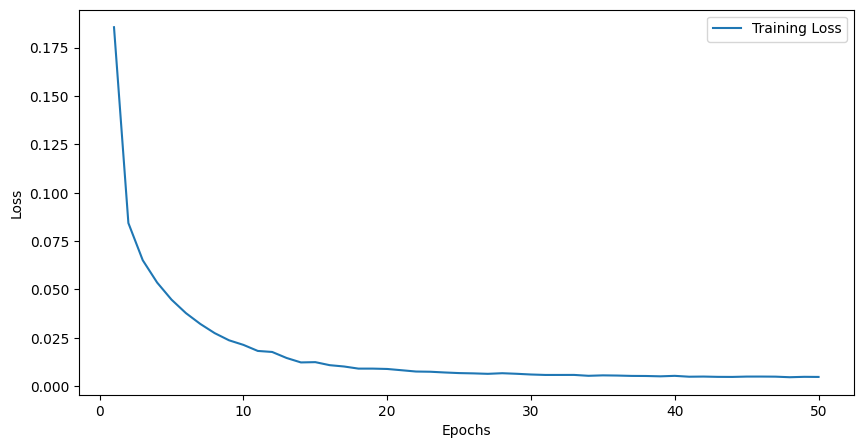

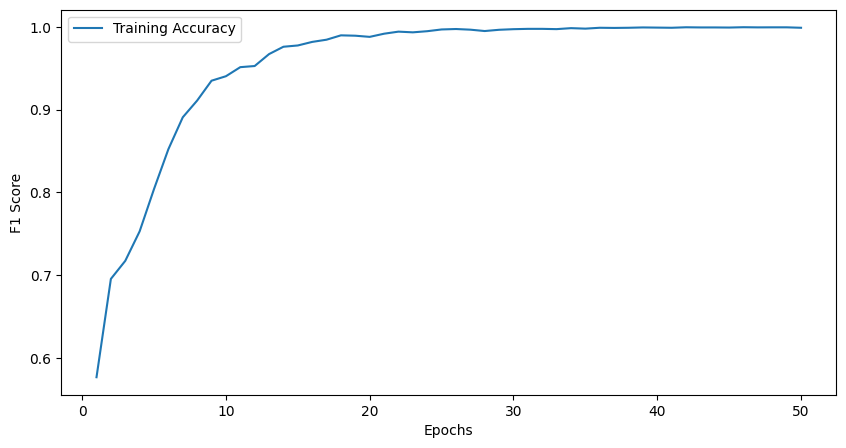

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import r2_score, f1_score
import time
import matplotlib.pyplot as plt

# Import Model
from hybridmodel import AdvancedQueryOptimizer

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess y_hints_train and y_hints_test to multi-label format
# Assuming y_hints_train is [num_samples] integers (e.g., 0 to 19 indicating a knob)
# Convert to [num_samples, 20] binary
def to_multi_label(y_hints, num_hints=20):
    num_samples = len(y_hints)
    y_multi = torch.zeros(num_samples, num_hints)
    for i, hint in enumerate(y_hints):
        if hint < num_hints:  # Ensure index is valid
            y_multi[i, hint] = 1
    return y_multi

# Convert data to PyTorch tensors & Move to Device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_hints_train_multi = to_multi_label(y_hints_train, num_hints=20).to(device)  # [num_samples, 20]
y_cost_train_tensor = torch.tensor(y_cost_train, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_hints_test_multi = to_multi_label(y_hints_test, num_hints=20).to(device)  # [num_samples, 20]
y_cost_test_tensor = torch.tensor(y_cost_test, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_hints_train_multi, y_cost_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

num_hints = 20

# Model
model = AdvancedQueryOptimizer(input_size=X_train.shape[1], hidden_size=256, num_hints=num_hints, num_outputs=1).to(device)

# Loss Functions
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, hint_pred, target):
        assert hint_pred.shape == target.shape, f"Shape mismatch: {hint_pred.shape} vs {target.shape}"
        similarity = F.cosine_similarity(hint_pred, target, dim=1)
        loss = torch.mean((1 - similarity) ** 2)
        return loss

# Loss functions
hint_criterion = FocalLoss()
contrastive_loss = ContrastiveLoss()
cost_criterion = nn.MSELoss()

# Tracking lists
total_losses, epoch_times = [], []
train_losses, train_cost_losses, train_knob_f1_scores, cost_history = [], [], [], []

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Dynamic Weighting Function
def compute_weighted_focus(costs, alpha=5.0, beta=0.5, min_weight=0.3):
    normalized_costs = (costs - costs.mean()) / (costs.std() + 1e-8)
    weights = torch.exp(alpha * -normalized_costs) + beta
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    weights = weights * (1 - min_weight) + min_weight
    return weights / torch.sum(weights)

# Training Loop with Early Stopping
num_epochs = 50
early_stopping_patience = 5
no_improve_count = 0
best_loss = float('inf')
best_model_path = "out/best/best_model.pth"

for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_cost_loss, total = 0.0, 0.0, 0
    all_cost_preds, all_cost_targets = [], []
    all_knob_preds, all_knob_targets = [], []

    start_time = time.time()
    for inputs, hints, costs in train_loader:
        optimizer.zero_grad()
        
        # Move batch to device (already on device, but kept for clarity)
        inputs, hints, costs = inputs.to(device), hints.to(device), costs.to(device)
        costs = costs.view(-1, 1)  # [batch_size, 1]

        # Forward pass
        hint_outputs, cost_outputs = model(inputs)  # hint_outputs: [batch_size, 20]

        # Compute losses
        hint_loss = hint_criterion(hint_outputs, hints)
        cost_loss = cost_criterion(cost_outputs, costs)
        hint_probs = torch.sigmoid(hint_outputs)
        contrastive_hint_loss = contrastive_loss(hint_probs, hints)

        # Weighted loss
        total_loss = 0.8 * hint_loss + 0.6 * cost_loss + 0.05 * contrastive_hint_loss
        total_loss.backward()
        optimizer.step()

        # Metrics
        batch_size = inputs.size(0)
        epoch_loss += total_loss.item() * batch_size
        epoch_cost_loss += cost_loss.item() * batch_size
        
        all_cost_preds.extend(cost_outputs.detach().cpu().numpy().flatten().tolist())
        all_cost_targets.extend(costs.detach().cpu().numpy().flatten().tolist())
        all_knob_preds.extend(hint_probs.detach().cpu().numpy().tolist())
        all_knob_targets.extend(hints.detach().cpu().numpy().tolist())
        total += batch_size

    avg_loss = epoch_loss / total
    avg_cost_loss = epoch_cost_loss / total
    
    knob_preds_binary = [1 if p >= 0.5 else 0 for pred in all_knob_preds for p in pred]
    knob_targets_binary = [t for target in all_knob_targets for t in target]
    knob_f1 = f1_score(knob_targets_binary, knob_preds_binary, average='macro') if knob_targets_binary else 0.0
    
    train_r2 = r2_score(all_cost_targets, all_cost_preds) if len(all_cost_targets) > 1 else float("nan")

    total_losses.append(avg_loss)
    train_losses.append(avg_loss)
    train_knob_f1_scores.append(knob_f1)
    train_cost_losses.append(avg_cost_loss)
    cost_history.append(all_cost_targets)
    
    epoch_times.append(time.time() - start_time)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Cost Loss: {avg_cost_loss:.4f}, Knob F1: {knob_f1:.4f}, Cost R²: {train_r2:.4f}, Time: {epoch_times[-1]:.2f}s")

    scheduler.step()
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at Epoch {epoch + 1} with Loss: {avg_loss:.4f}")
        no_improve_count = 0
    else:
        no_improve_count += 1

    if no_improve_count >= early_stopping_patience:
        print("🔴 Early stopping triggered.")
        break

# Load Best Model for Testing
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluation on Test Set
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_test_tensor)
    hint_probs = torch.sigmoid(hint_outputs)
    knob_preds_binary = (hint_probs.flatten().cpu().numpy() >= 0.5).astype(int)
    knob_targets_binary = y_hints_test_multi.flatten().cpu().numpy().astype(int)
    
    # Compute F1 with zero_division handling
    if not np.any(knob_targets_binary) and not np.any(knob_preds_binary):
        test_knob_f1 = 0.0  # Both all zeros, F1 is undefined but set to 0
        print("Warning: Both predictions and targets are all zeros for knobs.")
    else:
        test_knob_f1 = f1_score(knob_targets_binary, knob_preds_binary, average='macro', zero_division=0)
    
    cost_mae = torch.abs(cost_outputs.squeeze() - y_cost_test_tensor.squeeze()).mean().item()
    test_r2 = r2_score(y_cost_test_tensor.cpu().numpy().flatten(), cost_outputs.cpu().numpy().flatten())

    print(f"🔍 Final Test Knob F1: {test_knob_f1:.4f}")
    print(f"📉 Final Test Cost MAE: {cost_mae:.4f}")
    print(f"📊 Final Test Cost R²: {test_r2:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_knob_f1_scores) + 1), train_knob_f1_scores, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [96]:
print("Training X shape:", X_train_tensor.shape)
print("Validation X shape:", X_val_tensor.shape)


Training X shape: torch.Size([4000, 35670])
Validation X shape: torch.Size([4929, 35670])


In [97]:
import torch

# Define the device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and move to device
model.to(device)
model.eval()

# Move tensors to the same device
X_val_tensor = X_val_tensor.to(device)
y_hints_val_tensor = y_hints_val_tensor.to(device)
y_cost_val_tensor = y_cost_val_tensor.to(device)

# Perform inference
with torch.no_grad():
    hint_outputs, cost_outputs = model(X_val_tensor)

    # Compute hint accuracy
    _, predicted = torch.max(hint_outputs, 1)
    hint_accuracy = (predicted == y_hints_val_tensor).sum().item() / y_hints_val_tensor.size(0)

    # Compute cost MAE
    cost_mae = torch.abs(cost_outputs.squeeze() - y_cost_val_tensor.squeeze()).mean().item()

    # Compute R² score
    test_r2 = r2_score(y_cost_val_tensor.cpu().numpy().flatten(), cost_outputs.cpu().numpy().flatten())

    # Print results
    print(f"Final Val Hint Accuracy: {hint_accuracy * 100:.2f}%")
    print(f"Final Val Cost MAE: {cost_mae:.4f}")
    print(f"Final Val Cost R²: {test_r2:.4f}")


Final Val Hint Accuracy: 99.94%
Final Val Cost MAE: 0.0475
Final Val Cost R²: 0.8802


In [98]:
import numpy as np

# Assuming you already have y_cost_val_tensor (True Latency) and cost_outputs (Predicted Latency)

# Flatten the tensors into 1D arrays for ease of computation
true_latencies = y_cost_val_tensor.cpu().numpy().flatten()  # True Latency
predicted_latencies = cost_outputs.cpu().numpy().flatten()  # Predicted Latency

# Calculate the 90th percentile (P90) of the true latencies and predicted latencies
p90_true = np.percentile(true_latencies, 90)
p90_predicted = np.percentile(predicted_latencies, 90)

print(f"P90 True Latency: {p90_true:.4f}")
print(f"P90 Predicted Latency: {p90_predicted:.4f}")


P90 True Latency: 0.8223
P90 Predicted Latency: 0.7903


In [99]:
import numpy as np

# Assuming you already have y_cost_val_tensor (True Latency) and cost_outputs (Predicted Latency)

# Flatten the tensors into 1D arrays for ease of computation
true_latencies = y_cost_val_tensor.cpu().numpy().flatten()  # True Latency
predicted_latencies = cost_outputs.cpu().numpy().flatten()  # Predicted Latency

# Calculate the 95th percentile (P95) of the true latencies and predicted latencies
p95_true = np.percentile(true_latencies, 95)
p95_predicted = np.percentile(predicted_latencies, 95)

print(f"P95 True Latency: {p95_true:.4f}")
print(f"P95 Predicted Latency: {p95_predicted:.4f}")


P95 True Latency: 0.8636
P95 Predicted Latency: 0.8422


In [100]:
import numpy as np

# Assuming you already have y_cost_val_tensor (True Latency) and cost_outputs (Predicted Latency)

# Flatten the tensors into 1D arrays for ease of computation
true_latencies = y_cost_val_tensor.cpu().numpy().flatten()  # True Latency
predicted_latencies = cost_outputs.cpu().numpy().flatten()  # Predicted Latency

# Calculate the 95th percentile (P95) of the true latencies and predicted latencies
p99_true = np.percentile(true_latencies, 99)
p99_predicted = np.percentile(predicted_latencies, 99)

print(f"P99 True Latency: {p99_true:.4f}")
print(f"P99 Predicted Latency: {p99_predicted:.4f}")


P99 True Latency: 0.9201
P99 Predicted Latency: 0.8842


In [101]:
total_latency_true = np.sum(true_latencies)  # Sum of true latencies
total_latency_predicted = np.sum(predicted_latencies)  # Sum of predicted latencies

print(f"Total True Latency: {total_latency_true:.4f}")
print(f"Total Predicted Latency: {total_latency_predicted:.4f}")



Total True Latency: 3038.8438
Total Predicted Latency: 2914.5181


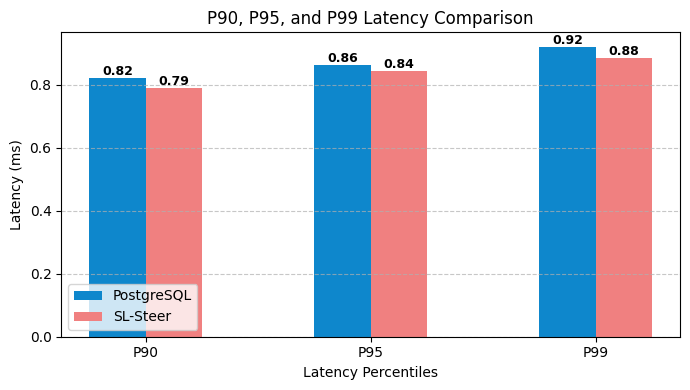

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have y_cost_val_tensor (True Latency) and cost_outputs (Predicted Latency)
true_latencies = y_cost_test_tensor.cpu().numpy().flatten()  # True Latency
predicted_latencies = cost_outputs.cpu().numpy().flatten()  # Predicted Latency

# Calculate P90, P95, and P99
p90_true = np.percentile(p90_true, 90)
p95_true = np.percentile(p95_true, 95)
p99_true = np.percentile(p99_true, 99)

p90_predicted = np.percentile(p90_predicted, 90)
p95_predicted = np.percentile(p95_predicted, 95)
p99_predicted = np.percentile(p99_predicted, 99)

# Define labels and values
percentiles = ["P90", "P95", "P99"]
true_values = [p90_true, p95_true, p99_true]
predicted_values = [p90_predicted, p95_predicted, p99_predicted]

x = np.arange(len(percentiles))  # X locations for the groups
width = 0.25  # Width of the bars

# Create plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot bars
rects1 = ax.bar(x - width/2, true_values, width, label="PostgreSQL", color="#0E87CC", capsize=8)
rects2 = ax.bar(x + width/2, predicted_values, width, label="SL-Steer", color="lightcoral", capsize=8)

# Add labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}",
                ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# Formatting
ax.set_xlabel("Latency Percentiles")
ax.set_ylabel("Latency (ms)")
ax.set_title("P90, P95, and P99 Latency Comparison")
ax.set_xticks(x)
ax.set_xticklabels(percentiles)
ax.legend()

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


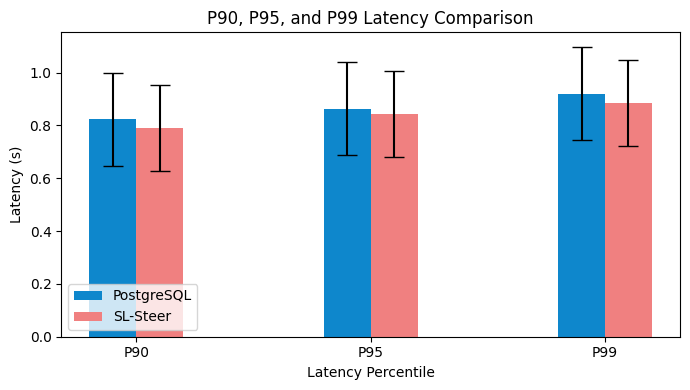

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'true_latency' and 'predicted_latency' are the arrays of latencies
true_latency = true_latencies # Example latencies, replace with your data
predicted_latency = predicted_latencies # Example predicted, replace with your data

# Calculate the P90, P95, P99 latencies
true_latency_p90 = np.percentile(p90_true, 90)
true_latency_p95 = np.percentile(p95_true, 95)
true_latency_p99 = np.percentile(p99_true, 99)

predicted_latency_p90 = np.percentile(p90_predicted, 90)
predicted_latency_p95 = np.percentile(p95_predicted, 95)
predicted_latency_p99 = np.percentile(p99_predicted, 99)

# Calculate standard deviation for error bars (for visualization)
true_latency_std = np.std(true_latency)
predicted_latency_std = np.std(predicted_latency)

# Plot the results in a bar chart
labels = ['P90', 'P95', 'P99']
true_latencies = [true_latency_p90, true_latency_p95, true_latency_p99]
predicted_latencies = [predicted_latency_p90, predicted_latency_p95, predicted_latency_p99]

# Create the bar plot
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 4))

# Plot bars for True Latency and Predicted Latency
rects1 = ax.bar(x - width/2, true_latencies, width, label='PostgreSQL', color='#0E87CC', yerr=true_latency_std, capsize=7)
rects2 = ax.bar(x + width/2, predicted_latencies, width, label='SL-Steer', color='lightcoral', yerr=predicted_latency_std, capsize=7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Latency Percentile')
ax.set_ylabel('Latency (s)')
ax.set_title('P90, P95, and P99 Latency Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


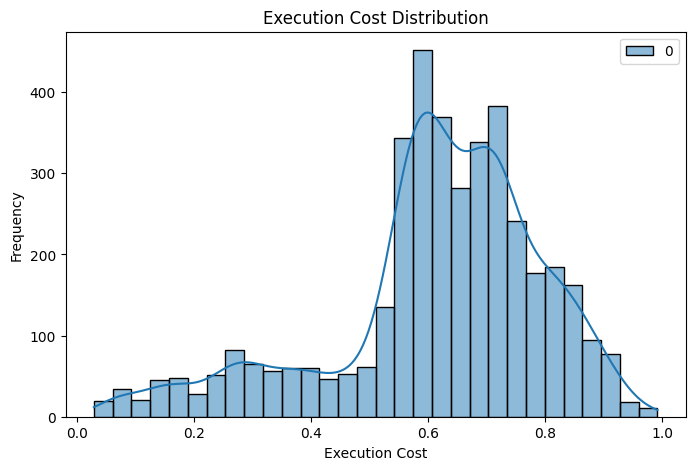

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y_cost_train, bins=30, kde=True, color='blue')
plt.title("Execution Cost Distribution")
plt.xlabel("Execution Cost")
plt.ylabel("Frequency")
plt.show()


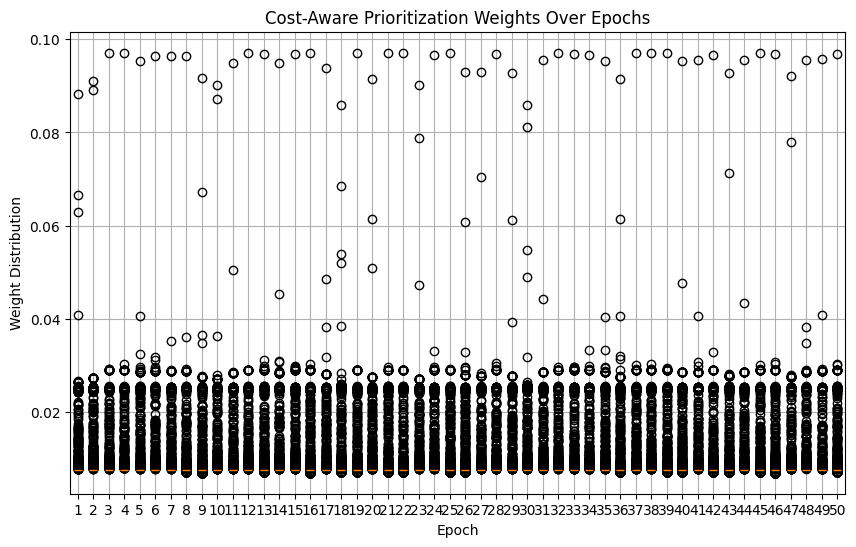

In [106]:
import matplotlib.pyplot as plt
import numpy as np

weight_history = []  # Store weight distributions
# 🔹 **Balanced Weighting: Prioritizing Low Execution Time but Keeping Full Query Space**
for epoch in range(num_epochs):
    epoch_weights = []

    for inputs, hints, costs in train_loader:
        weights = compute_weighted_focus(costs)
        epoch_weights.extend(weights.detach().cpu().numpy().flatten().tolist())  # Ensure 1D list

    weight_history.append(epoch_weights)  # Ensure list of lists

# Convert weight_history to a list of lists for plotting
weight_history = [np.array(epoch_weights).flatten().tolist() for epoch_weights in weight_history]

# **Plot Weight Distribution Over Epochs**
plt.figure(figsize=(10, 6))
plt.boxplot(weight_history, vert=True, patch_artist=True)
plt.xlabel("Epoch")
plt.ylabel("Weight Distribution")
plt.title("Cost-Aware Prioritization Weights Over Epochs")
plt.grid(True)
plt.show()



Sample Predictions with Costs:
Sample 1:
  True Knob: Seq Scan | True Cost: 0.63
  Predicted Knob: Seq Scan | Predicted Cost: 0.58
--------------------------------------------------
Sample 2:
  True Knob: Sort | True Cost: 0.60
  Predicted Knob: Sort | Predicted Cost: 0.59
--------------------------------------------------
Sample 3:
  True Knob: Sort | True Cost: 0.69
  Predicted Knob: Sort | Predicted Cost: 0.60
--------------------------------------------------
Sample 4:
  True Knob: Gather | True Cost: 0.59
  Predicted Knob: Gather | Predicted Cost: 0.58
--------------------------------------------------
Sample 5:
  True Knob: Gather | True Cost: 0.51
  Predicted Knob: Gather | Predicted Cost: 0.34
--------------------------------------------------
Sample 6:
  True Knob: Gather | True Cost: 0.70
  Predicted Knob: Gather | Predicted Cost: 0.68
--------------------------------------------------
Sample 7:
  True Knob: Sort | True Cost: 0.61
  Predicted Knob: Sort | Predicted Cost: 0.6

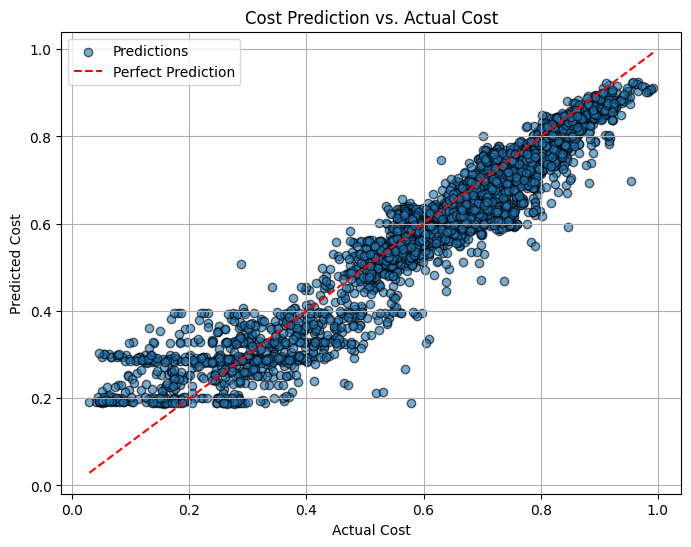

In [108]:
predicted_knobs = []
true_knobs = []
predicted_costs_list = []  # Temporary list for predicted costs
true_costs_list = []  # Temporary list for true costs
total_samples = 0
total_matches = 0
with torch.no_grad():
    # Get model predictions (both hint and cost)
    hint_outputs, cost_outputs = model(X_val_tensor)  

    # Convert logits to class indices for hint predictions
    _, predicted_hints = torch.max(hint_outputs, 1)  
    predicted_hints = predicted_hints.cpu().numpy()
    y_test_hints_np = y_hints_val_tensor.cpu().numpy()

    # Convert cost outputs to numpy (flattened for easier comparison)
    predicted_costs = cost_outputs.cpu().numpy().flatten()
    true_costs = y_cost_val_tensor.cpu().numpy().flatten()

# Convert numerical indices to knob names and store costs
for pred_idx, true_idx, pred_cost, true_cost in zip(predicted_hints, y_test_hints_np, predicted_costs, true_costs):
    true_knob = encoding.idx2type.get(true_idx, f"Unknown ({true_idx})")  # Handle missing mappings
    pred_knob = encoding.idx2type.get(pred_idx, f"Unknown ({pred_idx})")

    predicted_knobs.append(pred_knob)
    true_knobs.append(true_knob)
    predicted_costs_list.append(pred_cost)
    true_costs_list.append(true_cost)

       # Count matches
    total_samples += 1
    if pred_knob == true_knob:
        total_matches += 1

# Convert cost lists into NumPy arrays
predicted_costs = np.array(predicted_costs_list)
true_costs = np.array(true_costs_list)

# Print first 10 predictions with associated costs for verification
print("\nSample Predictions with Costs:")
for i in range(min(10, len(true_knobs))):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]} | True Cost: {true_costs[i]:.2f}")
    # | True Cost: {true_costs[i]:.2f}
    print(f"  Predicted Knob: {predicted_knobs[i]} | Predicted Cost: {predicted_costs[i]:.2f}")
    print("-" * 50)

# Print total matches
match_percentage = (total_matches / total_samples) * 100
print(f"\nTotal Matches: {total_matches}/{total_samples} ({match_percentage:.2f}%)")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_costs, predicted_costs, alpha=0.6, edgecolors='k', label="Predictions")

# Plot y=x line for reference (Perfect Prediction Line)
plt.plot([min(true_costs), max(true_costs)], [min(true_costs), max(true_costs)], 
         color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Cost Prediction vs. Actual Cost")
plt.legend()
plt.grid(True)

#Show the plot
plt.show()

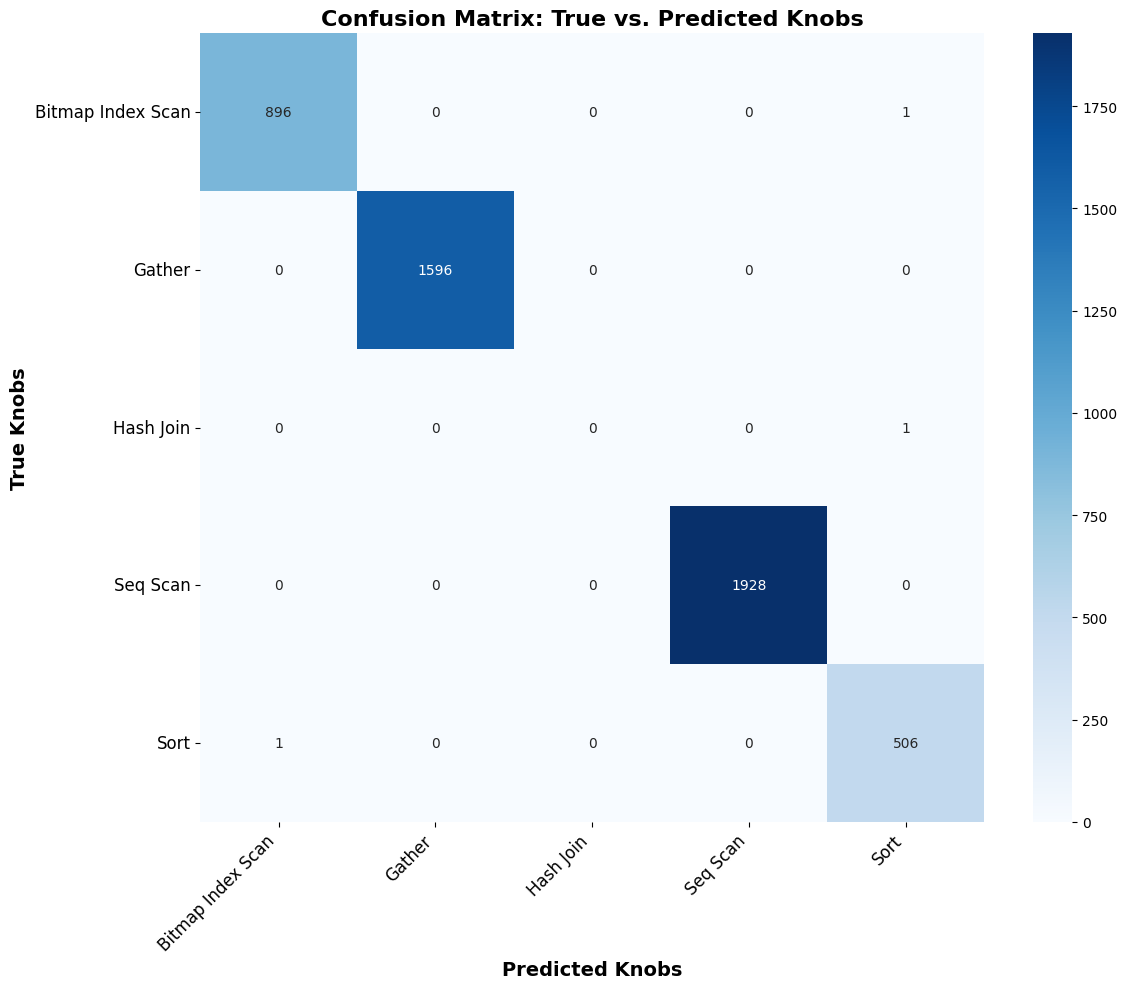

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure all knob labels are consistently strings
true_knobs = [str(knob) for knob in true_knobs]  # Convert all to strings
predicted_knobs = [str(knob) for knob in predicted_knobs]

# Get sorted unique knob names
unique_knobs = sorted(set(true_knobs + predicted_knobs))

# Create mappings for labels
knob2idx = {knob: idx for idx, knob in enumerate(unique_knobs)}
idx2knob = {idx: knob for knob, idx in knob2idx.items()}

# Convert knob names to indices
true_indices = [knob2idx[knob] for knob in true_knobs]
pred_indices = [knob2idx[knob] for knob in predicted_knobs]

# Compute confusion matrix
cm = confusion_matrix(true_indices, pred_indices)

# Plot the confusion matrix with real labels
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_knobs, yticklabels=unique_knobs)

plt.xlabel("Predicted Knobs", fontsize=14, fontweight='bold')
plt.ylabel("True Knobs", fontsize=14, fontweight='bold')
plt.title("Confusion Matrix: True vs. Predicted Knobs", fontsize=16, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


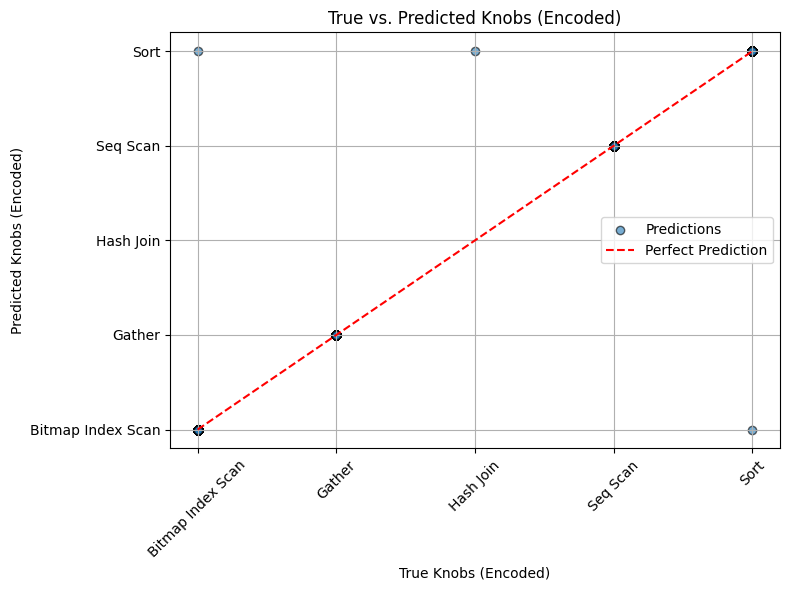

In [110]:
# Encode knobs numerically (same mapping as above)
true_encoded = [knob2idx[knob] for knob in true_knobs]
pred_encoded = [knob2idx[knob] for knob in predicted_knobs]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_encoded, pred_encoded, alpha=0.6, edgecolors='k', label="Predictions")

# Plot y=x line for reference (Perfect Prediction Line)
plt.plot([min(true_encoded), max(true_encoded)], [min(true_encoded), max(true_encoded)], 
         color='red', linestyle='--', label="Perfect Prediction")

# Set labels and title
plt.xlabel("True Knobs (Encoded)")
plt.ylabel("Predicted Knobs (Encoded)")
plt.title("True vs. Predicted Knobs (Encoded)")
plt.legend()
plt.grid(True)

# Add knob names as tick labels
plt.xticks(range(len(unique_knobs)), [idx2knob[i] for i in range(len(unique_knobs))], rotation=45)
plt.yticks(range(len(unique_knobs)), [idx2knob[i] for i in range(len(unique_knobs))])
plt.tight_layout()
plt.show()

In [111]:
# Track mismatches
mismatch_count = 0
total_samples = len(true_knobs)

# Store mismatched samples with associated costs
mismatched_samples = []

for i in range(total_samples):
    if true_knobs[i] != predicted_knobs[i]:  # Identify mismatches
        mismatch_count += 1
        cost_diff = abs(true_costs[i] - predicted_costs[i])  # Calculate cost difference
        mismatched_samples.append((i + 1, true_knobs[i], predicted_knobs[i], true_costs[i], predicted_costs[i], cost_diff))

# Print mismatch details
if mismatched_samples:
    print("\nMismatched Predictions with Costs:")
    for i, true_knob, predicted_knob, true_cost, predicted_cost, cost_diff in mismatched_samples[:10]:  # Print first 10 mismatches
        print(f"Sample {i}: ❌ Mismatch")
        print(f"  True Knob: {true_knob} | True Cost: {true_cost:.2f}")
        print(f"  Predicted Knob: {predicted_knob} | Predicted Cost: {predicted_cost:.2f}")
        print(f"  Cost Difference: {cost_diff:.2f}")
        print("-" * 50)

# Print overall error rate and average cost difference
if total_samples > 0:
    error_rate = (mismatch_count / total_samples) * 100
    avg_cost_diff = sum([x[5] for x in mismatched_samples]) / mismatch_count if mismatch_count > 0 else 0
    print(f"\nTotal Mismatches: {mismatch_count}/{total_samples} ({error_rate:.2f}%)")
    print(f"Average Cost Difference for Mismatches: {avg_cost_diff:.2f}")
else:
    print("\nNo samples found.")



Mismatched Predictions with Costs:
Sample 703: ❌ Mismatch
  True Knob: Hash Join | True Cost: 0.86
  Predicted Knob: Sort | Predicted Cost: 0.82
  Cost Difference: 0.04
--------------------------------------------------
Sample 962: ❌ Mismatch
  True Knob: Bitmap Index Scan | True Cost: 0.74
  Predicted Knob: Sort | Predicted Cost: 0.61
  Cost Difference: 0.12
--------------------------------------------------
Sample 4750: ❌ Mismatch
  True Knob: Sort | True Cost: 0.59
  Predicted Knob: Bitmap Index Scan | Predicted Cost: 0.58
  Cost Difference: 0.01
--------------------------------------------------

Total Mismatches: 3/4929 (0.06%)
Average Cost Difference for Mismatches: 0.06


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Initialize dictionary using unique true knob names instead of numerical labels
cost_diffs = {knob: [] for knob in set(true_knobs)}

# Track cost difference per knob type (for mismatches)
for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        if true_knobs[i] not in cost_diffs:
            cost_diffs[true_knobs[i]] = []  # Ensure key exists
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per knob type
avg_cost_diff_per_knob = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}



# Print cost differences for mismatched predictions
print("\nAverage Cost Difference Per Knob Type (for Mismatches):")
for knob, avg_cost in avg_cost_diff_per_knob.items():
    print(f"  Knob: {knob} → Avg Cost Difference: {avg_cost:.2f}")



Average Cost Difference Per Knob Type (for Mismatches):
  Knob: Bitmap Index Scan → Avg Cost Difference: 0.12
  Knob: Seq Scan → Avg Cost Difference: 0.00
  Knob: Sort → Avg Cost Difference: 0.01
  Knob: Hash Join → Avg Cost Difference: 0.04
  Knob: Gather → Avg Cost Difference: 0.00


In [113]:
from collections import defaultdict
import numpy as np

# Track cost differences for mismatched predictions
cost_diffs = defaultdict(list)

for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Mismatch case
        cost_diffs[true_knobs[i]].append(abs(true_costs[i] - predicted_costs[i]))

# Compute mean cost difference per class
avg_cost_diff_per_class = {k: (sum(v) / len(v) if v else 0) for k, v in cost_diffs.items()}

# Print cost impact of misclassifications
print("\nAverage Cost Difference for Misclassified Hints:")
for hint, avg_cost in avg_cost_diff_per_class.items():
    print(f"  {hint}: {avg_cost:.2f} ms")

# Compute overall cost impact
total_cost_mismatch = sum([sum(v) for v in cost_diffs.values()])
print(f"\nTotal Cost Penalty due to Incorrect Hints: {total_cost_mismatch:.2f} ms")



Average Cost Difference for Misclassified Hints:
  Hash Join: 0.04 ms
  Bitmap Index Scan: 0.12 ms
  Sort: 0.01 ms

Total Cost Penalty due to Incorrect Hints: 0.18 ms


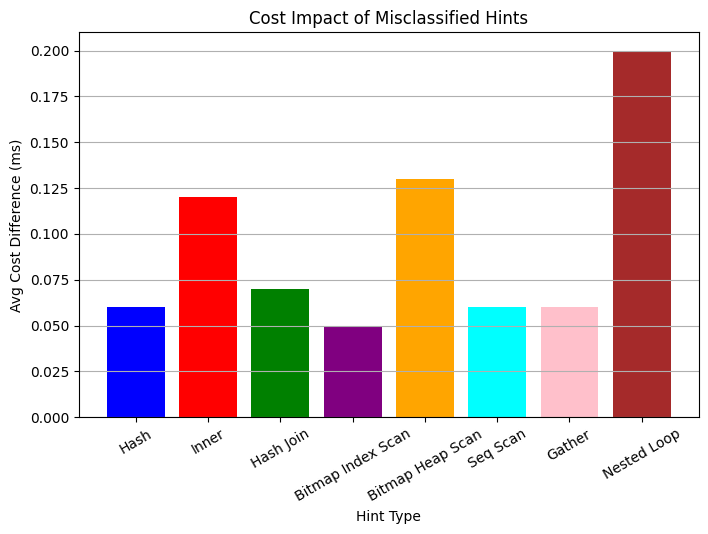

In [114]:
import matplotlib.pyplot as plt

# Data from results
hint_types = ["Hash", "Inner", "Hash Join", "Bitmap Index Scan", 
              "Bitmap Heap Scan", "Seq Scan", "Gather", "Nested Loop"]
avg_costs = [0.06, 0.12, 0.07, 0.05, 0.13, 0.06, 0.06, 0.20]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(hint_types, avg_costs, color=['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'pink', 'brown'])
plt.xlabel("Hint Type")
plt.ylabel("Avg Cost Difference (ms)")
plt.title("Cost Impact of Misclassified Hints")
plt.xticks(rotation=30)
plt.grid(axis="y")

# Show plot
plt.show()
